<h1 align="center">Introduction to Machine Learning - Course Code: 25737</h1>
<h4 align="center">Instructor: Dr. Amiri</h4>
<h4 align="center">Sharif University of Technology, Spring 2024</h4>
<h4 align="center">Computer Assignment 3</h4>
<h4 align="center">

Question 2

</h4>

# Personal Data

In [ ]:
# Set your student number
student_number = 400101356
Name = 'Ali'
Last_Name = 'Soltani'

# Rules
- You are not allowed to add or remove cells. You **must use the provided space to write your code**. If you don't follow this rule, **your Practical Assignment won't be graded**.  

- Collaboration and using the internet is allowed, but your code **must be written by yourself**. **Copying code** from each other or from available resources will result in a **zero score for the assignment**.

- You are not allowed to use `torch.nn`, `torch.optim` and any activation function and loss function implemented in torch.

## Question 1) Convolutional Neural Networks ``(50 pt.)``

In this question, you'll be coding up a convolutional neural network from scratch to classify images using PyTorch.  

### Instructions
- Install PyTorch following the instructions [here](https://pytorch.org/).
- Install the [`torchinfo` package](https://github.com/TylerYep/torchinfo) to visualize the network architecture and the number of parameters. The maximum number of parameters you are allowed to use for your network is **100,000**.
- You are required to complete the functions defined in the code blocks following each question. Fill out sections of the code marked `"YOUR CODE HERE"`.
- You're free to add any number of methods within each class.
- You may also add any number of additional code blocks that you deem necessary.

### Data Preparation
In this assignment, we will use the Fashion-MNIST dataset. Fashion-MNIST is a dataset of Zalando's article images—consisting of a training set of 60,000 examples and a test set of 10,000 examples. Each example is a 28x28 grayscale image, associated with a label from 10 classes.  

#### Data

Each image is 28 pixels in height and 28 pixels in width, for a total of 784 pixels in total. Each pixel has a single pixel-value associated with it, indicating the lightness or darkness of that pixel, with higher numbers meaning darker. This pixel-value is an integer between 0 and 255.  

#### Labels

Each training and test example is assigned to one of the following labels:

| Label | Description |
|-------|-------------|
| 0     | T-shirt/top |
| 1     | Trouser     |
| 2     | Pullover    |
| 3     | Dress       |
| 4     | Coat        |
| 5     | Sandal      |
| 6     | Shirt       |
| 7     | Sneaker     |
| 8     | Bag         |
| 9     | Ankle boot  |

Fashion-MNIST is included in the `torchvision` library.

In [ ]:
# Import required packages
from torchvision.datasets import FashionMNIST
from torchvision.transforms import Compose, ToTensor, Normalize
import matplotlib.pyplot as plt
import torch
import torchvision
import numpy as np
from torch import optim

In [ ]:
# Transform to normalize the data and convert to a tensor
transform = Compose([ToTensor(), Normalize((0.5,), (0.5,))])

# Download the data
dataset = FashionMNIST('MNIST_data/', download = True, train = True, transform = transform)

### Data Exploration
Let's take a look at the classes in our dataset.

In [ ]:
print(dataset.classes)

['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']


Now, visualize an instance from each class.

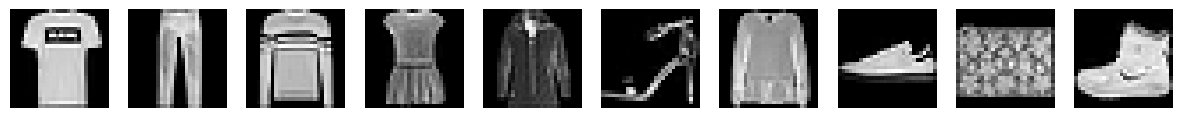

In [ ]:
######################
_, axs = plt.subplots(1, 10, figsize=(15, 10))
for i in range(10):
    idxs = torch.where(dataset.targets == i)[0]
    img = dataset[idxs[0]][0].squeeze().numpy()
    axs[i].imshow(img, cmap='gray')
    axs[i].axis('off')
plt.show()
######################

### Creating Training and Validation Datasets

The `split_indices` function takes in the size of the entire dataset, `n`, the fraction of data to be used as validation set, `val_frac`, and the random seed and returns the indices of the data points to be added to the validation dataset.

In [ ]:
def split_indices(n, val_frac, seed):
    # Determine the size of the validation set
    n_val = int(val_frac * n)
    np.random.seed(seed)
    # Create random permutation between 0 to n-1
    idxs = np.random.permutation(n)
    # Pick first n_val indices for validation set
    return idxs[n_val:], idxs[:n_val]

In [ ]:
######################
#   YOUR CODE HERE   #
######################
val_frac =  0.2
rand_seed =  17

train_indices, val_indices = split_indices(len(dataset), val_frac, rand_seed)
print("number of samples in training set: {}".format(len(train_indices)))
print("number of samples in validation set: {}".format(len(val_indices)))

number of samples in training set: 48000
number of samples in validation set: 12000


Next, we make use of the built-in dataloaders in PyTorch to create iterables of our our training and validation sets. This helps in avoiding fitting the whole dataset into memory and only loads a batch of the data that we can decide.

In [ ]:
# Import required packages
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data.dataloader import DataLoader

In [ ]:
######################
#   YOUR CODE HERE   #
######################
batch_size = 50

# Training sampler and data loader
train_sampler = SubsetRandomSampler(train_indices)
train_dl = DataLoader(dataset,
                     batch_size,
                     sampler=train_sampler)

# Validation sampler and data loader
val_sampler = SubsetRandomSampler(val_indices)
val_dl = DataLoader(dataset,
                   batch_size,
                   sampler=val_sampler)

Plot images in a sample batch of data.

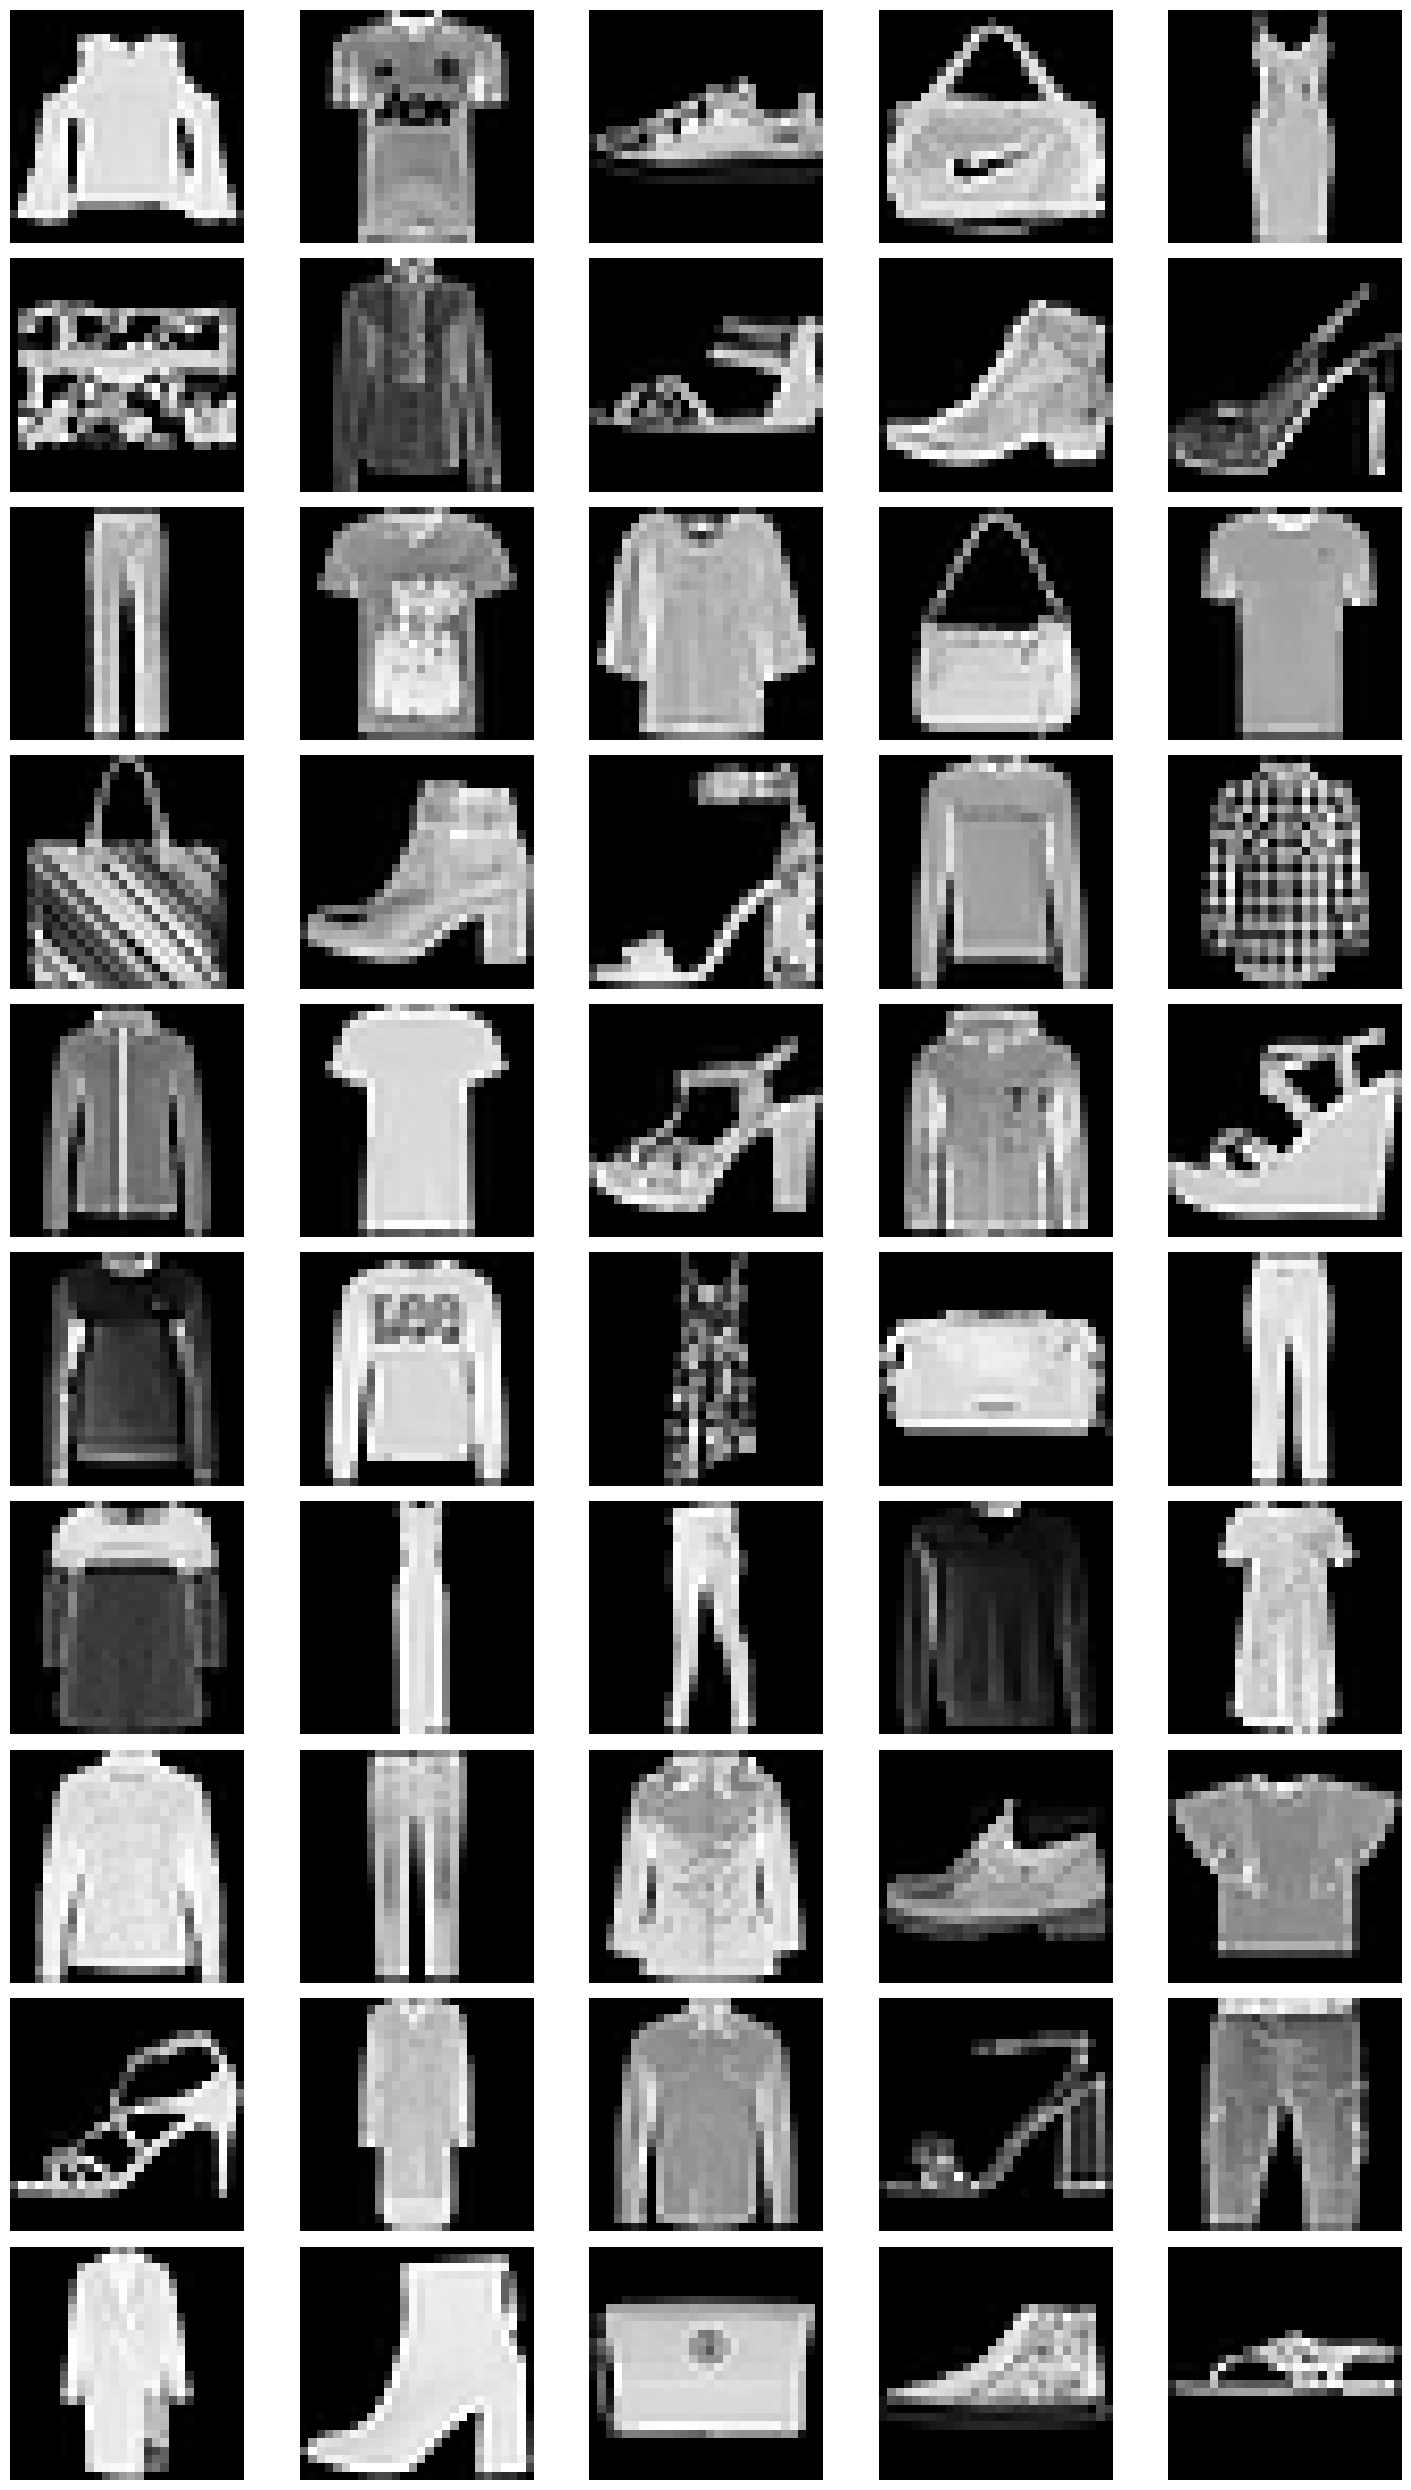

In [ ]:
######################
batch_data, _ = next(iter(train_dl))
_, axs = plt.subplots(batch_size // 5, 5, figsize=(15, 25))
axs = axs.flatten()
for i in range(batch_size):
    img = batch_data[i].squeeze().numpy()
    axs[i].imshow(img, cmap='gray')
    axs[i].axis('off')
plt.tight_layout()
plt.show()
######################

### Building the Model
Create your model by defining the network architecture in the `ImageClassifierNet` class.<br>
**NOTE:** The number of parameters in your network must be $\leq$ 100,000.

In [ ]:
# Import required packages
import torch.nn as nn
import torch.nn.functional as F
!pip install torchinfo
from torchinfo import summary

In [ ]:
class ImageClassifierNet(nn.Module):
    def __init__(self, n_channels=1, num_classes=10):
        super(ImageClassifierNet, self).__init__()
        ######################
        # Convolutional layers
        self.conv1 = nn.Conv2d(n_channels, 8, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(8, 16, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        # Max Pooling layer
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        # Calculate the input size for the fully connected layer
        self.fc_input_size = 32 * 3 * 3
        # Fully connected layers
        self.fc1 = nn.Linear(self.fc_input_size, 128)
        self.fc2 = nn.Linear(128, num_classes)
        ######################

    def forward(self, X):
        ######################
        X = self.pool(F.relu(self.conv1(X)))
        X = self.pool(F.relu(self.conv2(X)))
        X = self.pool(F.relu(self.conv3(X)))
        X = X.view(-1, self.fc_input_size)
        X = F.relu(self.fc1(X))
        X = self.fc2(X)
        return X
        ######################

In [ ]:
model = ImageClassifierNet()

The following code block prints your network architecture. It also shows the total number of parameters in your network (see `Total params`).  

**NOTE: The total number of parameters in your model should be <= 100,000.**

In [ ]:
summary(model, input_size=(batch_size, 1, 28, 28))

Layer (type:depth-idx)                   Output Shape              Param #
ImageClassifierNet                       [50, 10]                  --
├─Conv2d: 1-1                            [50, 8, 28, 28]           80
├─MaxPool2d: 1-2                         [50, 8, 14, 14]           --
├─Conv2d: 1-3                            [50, 16, 14, 14]          1,168
├─MaxPool2d: 1-4                         [50, 16, 7, 7]            --
├─Conv2d: 1-5                            [50, 32, 7, 7]            4,640
├─MaxPool2d: 1-6                         [50, 32, 3, 3]            --
├─Linear: 1-7                            [50, 128]                 36,992
├─Linear: 1-8                            [50, 10]                  1,290
Total params: 44,170
Trainable params: 44,170
Non-trainable params: 0
Total mult-adds (M): 27.86
Input size (MB): 0.16
Forward/backward pass size (MB): 4.45
Params size (MB): 0.18
Estimated Total Size (MB): 4.78

### Train the model
Complete the `train_model` function to train your model on a dataset. Tune your network architecture and hyperparameters on the validation set.

In [ ]:
def train_model(n_epochs, model, train_dl, val_dl, loss_fn, opt_fn, lr):
    """
    Trains the model on a dataset.

    Args:
        n_epochs: number of epochs
        model: ImageClassifierNet object
        train_dl: training dataloader
        val_dl: validation dataloader
        loss_fn: the loss function
        opt_fn: the optimizer
        lr: learning rate

    Returns:
        The trained model.
        A tuple of (model, train_losses, val_losses, train_accuracies, val_accuracies)
    """
    # Record these values the end of each epoch
    train_losses, val_losses, train_accuracies, val_accuracies = [], [], [], []

    ######################
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    optimizer = opt_fn(model.parameters(), lr=lr)
    for epoch in range(n_epochs):
        print("Epoch", epoch, ":")
        model.train()
        running_loss = 0.0
        correct = 0
        for X, y in train_dl:
            X, y = X.to(device), y.to(device)
            optimizer.zero_grad()
            outputs = model(X)
            loss = loss_fn(outputs, y)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            if (loss.item() < 0.5):
                correct += 1
        train_losses.append(running_loss / len(train_dl) if (len(train_dl)!=0) else 0)
        train_accuracies.append(correct / len(train_dl) if (len(train_dl)!=0) else 0)

        model.eval()
        correct = 0
        total = 0
        running_loss = 0.0
        with torch.no_grad():
            for X, y in val_dl:
                X, y = X.to(device), y.to(device)
                y_pred = model(X)
                loss = loss_fn(y_pred, y)
                running_loss += loss.item()
                _, predicted = torch.max(y_pred.data, 1)
                total += y.size(0)
                correct += (predicted == y).sum().item()

        val_losses.append(running_loss / len(val_dl) if (len(val_dl)!=0) else 0)
        val_accuracies.append(correct / total if (total!=0) else 0)

        print(f'Train Loss: {train_losses[epoch]:.5f}')
        print(f'Validation Loss: {val_losses[epoch]:.5f}')
        print(f'Train Accuracy: {train_accuracies[epoch]:.4f}')
        print(f'Validation Accuracy: {val_accuracies[epoch]:.4f}')

    ######################

    return model, train_losses, val_losses, train_accuracies, val_accuracies

In [ ]:
######################
#   YOUR CODE HERE   #
######################
num_epochs = 20
loss_fn =  nn.CrossEntropyLoss()
opt_fn =  optim.Adam
lr =  0.001

In [ ]:
model, train_losses, val_losses, train_accuracies, val_accuracies = train_model(num_epochs, model, train_dl, val_dl, loss_fn, opt_fn, lr)

Epoch 0 :
Train Loss: 0.64397
Validation Loss: 0.43939
Train Accuracy: 0.3573
Validation Accuracy: 0.8352
Epoch 1 :
Train Loss: 0.39470
Validation Loss: 0.34220
Train Accuracy: 0.8323
Validation Accuracy: 0.8763
Epoch 2 :
Train Loss: 0.32981
Validation Loss: 0.30774
Train Accuracy: 0.9344
Validation Accuracy: 0.8863
Epoch 3 :
Train Loss: 0.29951
Validation Loss: 0.32121
Train Accuracy: 0.9625
Validation Accuracy: 0.8781
Epoch 4 :
Train Loss: 0.27454
Validation Loss: 0.28850
Train Accuracy: 0.9812
Validation Accuracy: 0.8930
Epoch 5 :
Train Loss: 0.25764
Validation Loss: 0.25919
Train Accuracy: 0.9844
Validation Accuracy: 0.9032
Epoch 6 :
Train Loss: 0.24209
Validation Loss: 0.27426
Train Accuracy: 0.9906
Validation Accuracy: 0.8982
Epoch 7 :
Train Loss: 0.23176
Validation Loss: 0.25328
Train Accuracy: 0.9927
Validation Accuracy: 0.9089
Epoch 8 :
Train Loss: 0.21932
Validation Loss: 0.25317
Train Accuracy: 0.9938
Validation Accuracy: 0.9085
Epoch 9 :
Train Loss: 0.20793
Validation Loss:

### Plot loss and accuracy

In [ ]:
def plot_accuracy(train_accuracies, val_accuracies):
    """Plot accuracies"""
    plt.plot(train_accuracies, "-x")
    plt.plot(val_accuracies, "-o")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend(["Training", "Validation"])
    plt.title("Accuracy vs. No. of epochs")

def plot_losses(train_losses, val_losses):
    """Plot losses"""
    plt.plot(train_losses, "-x")
    plt.plot(val_losses, "-o")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend(["Training", "Validation"])
    plt.title("Loss vs. No. of Epochs")

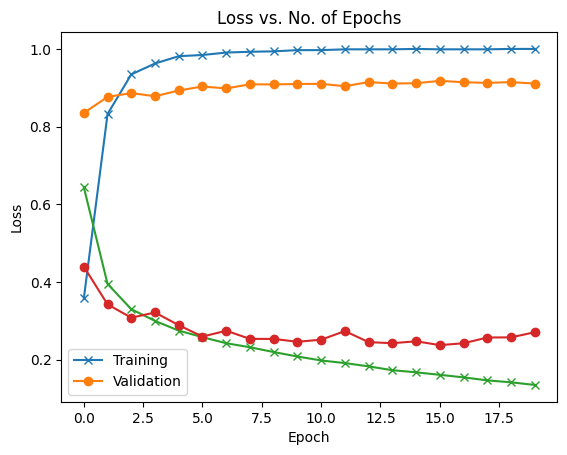

In [ ]:
plot_accuracy(train_accuracies, val_accuracies)
plot_losses(train_losses, val_losses)

### Train a model on the entire dataset

In [ ]:
indices, _ = split_indices(len(dataset), 0, rand_seed)

sampler = SubsetRandomSampler(indices)
dl = DataLoader(dataset, batch_size, sampler=sampler)

In [ ]:
######################
#   YOUR CODE HERE   #
######################
num_epochs = 20
lr = 0.001

In [157]:
model, _, _, _, _ = train_model(num_epochs, model, dl, [], loss_fn, opt_fn, lr)

Epoch 0 :
Train Loss: 0.58991
Validation Loss: 0.00000
Train Accuracy: 0.4742
Validation Accuracy: 0.0000
Epoch 1 :
Train Loss: 0.36939
Validation Loss: 0.00000
Train Accuracy: 0.8825
Validation Accuracy: 0.0000
Epoch 2 :
Train Loss: 0.31982
Validation Loss: 0.00000
Train Accuracy: 0.9433
Validation Accuracy: 0.0000
Epoch 3 :
Train Loss: 0.29247
Validation Loss: 0.00000
Train Accuracy: 0.9617
Validation Accuracy: 0.0000
Epoch 4 :
Train Loss: 0.27396
Validation Loss: 0.00000
Train Accuracy: 0.9825
Validation Accuracy: 0.0000
Epoch 5 :
Train Loss: 0.25524
Validation Loss: 0.00000
Train Accuracy: 0.9875
Validation Accuracy: 0.0000
Epoch 6 :
Train Loss: 0.23984
Validation Loss: 0.00000
Train Accuracy: 0.9967
Validation Accuracy: 0.0000
Epoch 7 :
Train Loss: 0.22842
Validation Loss: 0.00000
Train Accuracy: 0.9917
Validation Accuracy: 0.0000
Epoch 8 :
Train Loss: 0.21843
Validation Loss: 0.00000
Train Accuracy: 0.9958
Validation Accuracy: 0.0000
Epoch 9 :
Train Loss: 0.20708
Validation Loss:

### Check Predictions
Now, you should evaluate your model on dataset. Specifically, you should calculate the class probabilities for each image, and then visualize these probabilities along with the image itself. Please include a function `view_prediction` in your code that takes an image, its label, the calculated probabilities, and the list of class names as input, and plots the image along with the probabilities.

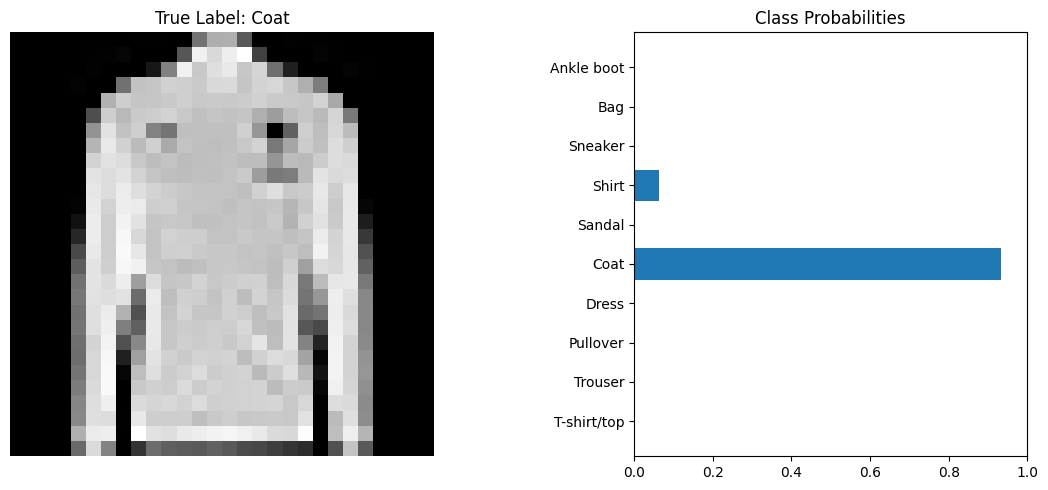

In [158]:
######################
def view_prediction(img, label, probabilities, class_names):
    fig, axs = plt.subplots(1, 2, figsize=(12, 5))
    # Show the image
    axs[0].imshow(img.squeeze(), cmap='gray')
    axs[0].axis('off')
    axs[0].set_title(f"True Label: {class_names[label]}")
    # Show the class probabilities
    axs[1].barh(np.arange(len(class_names)), probabilities)
    axs[1].set_aspect(0.1)
    axs[1].set_yticks(np.arange(len(class_names)))
    axs[1].set_yticklabels(class_names)
    axs[1].set_title('Class Probabilities')
    axs[1].set_xlim([0, 1])
    plt.tight_layout()
    plt.show()


batch_data, batch_labels = next(iter(val_dl))
# Select a single sample from the batch
img, label = batch_data[0], batch_labels[0]
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.eval()
img = img.to(device).unsqueeze(0)
# Get the model's predictions
with torch.no_grad():
    output = model(img)
    probabilities = F.softmax(output, dim=1).cpu().numpy().flatten()
# Visualize the prediction
view_prediction(img.cpu(), label, probabilities, dataset.classes)
######################

### Save the model

In [159]:
torch.save(model, 'model')

### Calculate accuracy on the test set

In [160]:
test_dataset = FashionMNIST('MNIST_data/', download = True, train = False, transform = transform)
test_dl = DataLoader(test_dataset, batch_size)

In [161]:
def evaluate(model, test_dl):
    """
    Evaluates your model on the test data.

    Args:
        model: ImageClassifierNet object
        test_dl: test dataloader

    Returns:
        Test accuracy.
    """
    ######################
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.eval()
    correct = 0
    total = 0
    for data, label in test_dl:
        data, label = data.to(device), label.to(device)
        predicted = model(data)
        predicted_classes = predicted.argmax(dim=1)
        correct += (predicted_classes == label).sum().item()
        total += label.shape[0]

    accuracy = correct / total
    return accuracy
    ######################

In [162]:
print("Test Accuracy = {:.4f}".format(evaluate(model, test_dl)))

Test Accuracy = 0.9059
